In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load dataset

In [31]:
print("Loading")
train = pd.read_csv('data/data_format1/train_format1.csv').drop_duplicates()
test = pd.read_csv('data/data_format1/test_format1.csv').drop_duplicates()
user_info = pd.read_csv('data/data_format1/user_info_format1.csv').drop_duplicates()
user_log = pd.read_csv('data/data_format1/user_log_format1.csv')
print("Load success")

Loading
Load success


<b>1. Train data</b>
<ul>
<li>user_id</li>
<li>merchant_id</li>
<li>label: '1' denotes 'user_id' is a repeat buyer for 'merchant_id', while '0' is the opposite. </li>
</ul>

In [55]:
train.head(3)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1


<b>2. Teat data</b>
<ul>
<li>user_id</li>
<li>merchant_id</li>
<li>prob: probability </li>
</ul>

In [56]:
test.head(3)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN


<b>3. User information data</b>
<ul>
<li>user_id</li>
<li>age_range: 1 for [,18];
            2 for [18,24];  
            3 for [25,29];  
            4 for [30,34]; 
            5 for [35,39]; 
            6 for [40,49]; 
            7 and 8 for >= [50,];
0 and NULL for unknown.</li>
<li>gender:  0 for female, 1 for male, 2 and NULL for unknown.</li>
</ul>

In [57]:
user_info.head(3)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0


<b>4. User Log data</b>
<ul>
<li>user_id</li>
<li>item_id: goods</li>
<li>cat_id: category</li>
<li>seller_id: merchant_id</li>
<li>brand_id</li>
<li>time_stamp: mmdd</li>
<li>action_type: 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favourite</li>
</ul>

In [58]:
user_log.head(3)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0


# Data Cleaning
## A. Drop all nan and rename
1. Drop nan  
2. Rename seller_id to merchant_id  
In user_log, "seller_id" should be called as "merchant_id".  
It is a mistake by data provider.  

In [32]:
user_info.dropna(axis=0,how='all',inplace = True)
user_log.dropna(axis=0,how='all',inplace = True)

In [4]:
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

## B. Deal with missing value
### Find out missing colunms

In [21]:
def num_missing(x):
  return sum(x.isnull())

In [64]:
print("Missing values per column:")
print("Train data missing: \n", train.apply(num_missing, axis=0),'\n')
print("User_info data missing: \n", user_info.apply(num_missing, axis=0),'\n')
print("User_log data missing: \n", user_log.apply(num_missing, axis=0))

Missing values per column:
Train data missing: 
 user_id        0
merchant_id    0
label          0
dtype: int64 

User_info data missing: 
 user_id         0
age_range    2217
gender       6436
dtype: int64 

User_log data missing: 
 user_id            0
item_id            0
cat_id             0
merchant_id        0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64


### For User_info data
1. Observation of "age_range" and "gender" in histogram.

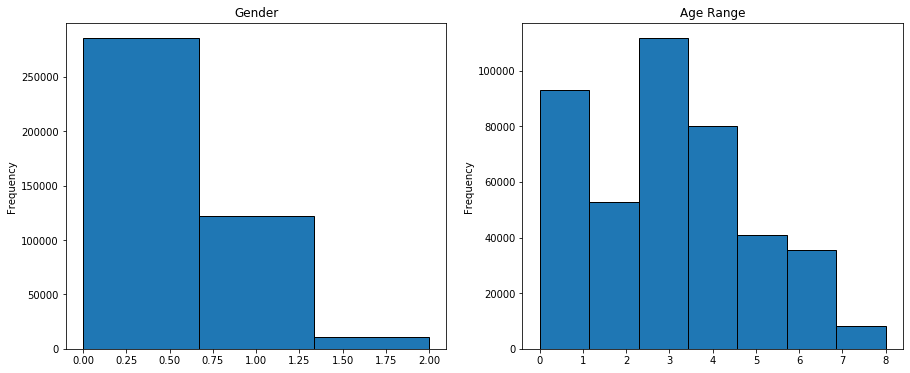

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 6), sharey=False)
user_info['gender'].plot.hist(ax=axes[0],bins=3,edgecolor='black', title="Gender")
user_info['age_range'].plot.hist(ax=axes[1],bins=7,edgecolor='black', title="Age Range")

2. Drop empty "gender" and "age_range" data

In [34]:
# fillna by by previous value
# user_info.fillna(method='ffill',inplace=True)
# dropna
user_info['age_range'] = user_info['age_range'].fillna(value=0)
user_info.dropna(subset=['gender'],inplace=True)

3. Check result.  

In [69]:
print("User_info data missing: \n", user_info.apply(num_missing, axis=0),'\n')

User_info data missing: 
 user_id      0
age_range    0
gender       0
dtype: int64 



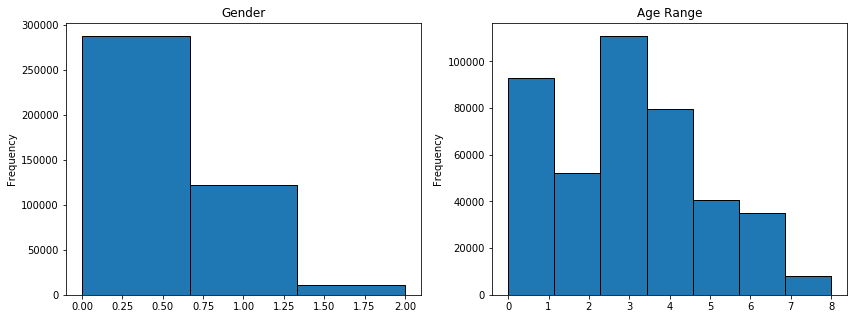

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14, 5), sharey=False)
user_info['gender'].plot.hist(ax=axes[0],bins=3,edgecolor='black', title="Gender")
user_info['age_range'].plot.hist(ax=axes[1],bins=7,edgecolor='black', title="Age Range")

### For User_log data
1. Principle: One brand contains multi items, but one item only belongs to one brand.

In [71]:
# Test relationship/principle
user_log[['item_id','brand_id']][user_log['item_id']==239288].head(3)

,item_id,brand_id
10,239288,4953.0
40817,239288,4953.0
55038,239288,4953.0


In [72]:
# Also have some items does not have brand_id
user_log[['item_id','brand_id']][user_log['item_id']==157368].head()

,item_id,brand_id
32109,157368,NaN


2. Fill missing value  
We can see that after fill lots of brand_id, user_log still has missing brand_id.
Some items don't have a mapped brand_id.

In [7]:
item_brand_dict = user_log.drop_duplicates(subset=['item_id','brand_id']).set_index('item_id')['brand_id'].to_dict()
user_log[user_log['brand_id'].isna()] = user_log[user_log['brand_id'].isna()].apply(lambda x: x.fillna(item_brand_dict[x['item_id']]), axis=1)
print("Done")

Done


4. Check the result.

In [75]:
print("In User_log, 'brand_id' still missing: \n", len(user_log[user_log['brand_id'].isna()]))

In User_log, 'brand_id' still missing: 
 86604


### Change Data Type
Save some space/memory

In [37]:
user_info[['age_range','gender']] = user_info[['age_range','gender']].astype('Int8')  # int8 : (from -128 to 127)
user_log[['user_id','item_id','cat_id']] = user_log[['user_id','item_id','cat_id']].astype('Int64')
user_log[['merchant_id','brand_id','time_stamp']] = user_log[['merchant_id','brand_id','time_stamp']].astype('Int16')
user_log[['action_type']] = user_log[['action_type']].astype('Int8')

In [38]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417734 entries, 0 to 424169
Data columns (total 3 columns):
user_id      417734 non-null int64
age_range    417734 non-null Int8
gender       417734 non-null Int8
dtypes: Int8(2), int64(1)
memory usage: 8.0 MB


In [82]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
user_id        Int64
item_id        Int64
cat_id         Int64
merchant_id    Int16
brand_id       Int16
time_stamp     Int16
action_type    Int8
dtypes: Int16(3), Int64(3), Int8(1)
memory usage: 2.4 GB


# Feature Extraction
## A. Method

In [103]:
def feature_extract(df:pd.DataFrame, cols, grop, aggs, rname, types):
    if types == 'cnt':
        return df[cols].groupby(grop, as_index=False).count().rename(columns=rname)
    
    if types == 'sub_agg':
        return df.groupby(grop, as_index=False).agg(aggs).rename(columns=rname)

### For User

1. Integrate user_info,  age_range and gender.

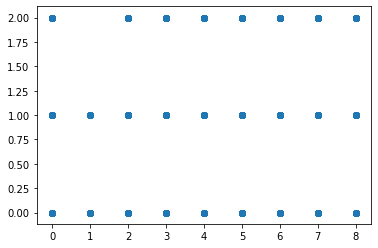

In [40]:
plt.scatter(user_info['age_range'], user_info['gender'])

In [71]:
kmeans = KMeans(init='k-means++', n_clusters=23) # the number of 23 is from the graph above
f_u_ag = kmeans.fit_predict(user_info[['age_range','gender']])
user_info['f_u_ag'] = f_u_ag


In [89]:
f_user = user_info.drop(columns=['age_range','gender'])
# user_info.drop(columns=['f_u_ag'], inplace=True)

2. Extract the count of action_types for all of the merchant  
3. Extract the count of merchant_id  
4. Extract the count of item_id  
5. Extract the count of cat_id(categary)  
5. Extract the count of brand_id

In [90]:
print('------Start------')

f_u_temp = feature_extract(user_log,['user_id','action_type'],['user_id'],None,{'action_type':'f_u_action'},'cnt')
f_user = pd.merge(f_user, f_u_temp, on=['user_id'])

aggs = {'merchant_id':lambda x: len(set(x)), 
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'merchant_id':'f_u_merchant','item_id':'f_u_item','cat_id':'f_u_cat','brand_id':'f_u_brand'}
f_u_temp = feature_extract(user_log, None, ['user_id'], aggs, rnames, 'sub_agg')
f_user = pd.merge(f_user, f_u_temp, on=['user_id'])

print('------Done------')

Start
Done


In [98]:
f_user

,user_id,f_u_action,f_u_merchant,f_u_item,f_u_cat,f_u_brand
0,376517,79,20,39,17,20
1,234512,56,21,29,18,20
2,344532,91,20,54,25,21
3,186135,200,11,21,11,10
4,30230,32,14,24,13,14
...,...,...,...,...,...,...
417729,297789,18,1,1,1,1
417730,395814,65,20,40,6,20
417731,245950,33,5,14,11,6
417732,272535,38,13,16,7,13


In [113]:
Normolization!!!! Meow

SyntaxError: invalid syntax (<ipython-input-113-ae3cb7f5fb17>, line 1)

### For Merchant
商铺下所有交互总次数  
商铺下交互的总用户数  
商铺下有多少被交互的商品，商品类别和商品品牌数量  
商铺每个月有多少用户交互  
商铺下交互的用户按年龄段和性别分别统计  
商铺在各个年龄段和性别组合的交互用户中交互的商品、商品类别和商品品牌总数  
商铺在各个年龄段和性别组合的购买用户中购买的商品、商品类别和商品品牌总数

In [105]:
f_merchant = pd.DataFrame(train['merchant_id']).drop_duplicates()

In [110]:
print('------Start------')

f_m_temp = feature_extract(user_log,['merchant_id','action_type'],['merchant_id'],None,{'action_type':'f_m_action'},'cnt')
f_merchant = pd.merge(f_merchant, f_m_temp, on=['merchant_id'])

aggs = {'user_id':lambda x: len(set(x)), 
        'item_id':lambda x: len(set(x)),
        'cat_id':lambda x: len(set(x)),
        'brand_id':lambda x: len(set(x))}
rnames = {'user_id':'f_m_user','item_id':'f_m_item','cat_id':'f_m_cat','brand_id':'f_m_brand'}
f_m_temp = feature_extract(user_log, None, ['merchant_id'], aggs, rnames, 'sub_agg')
f_merchant = pd.merge(f_merchant, f_m_temp, on=['merchant_id'])

print('------Done------')

------Start------
------Done------


In [111]:
f_merchant

,merchant_id,f_m_action_x,f_m_action_y,f_m_user,f_m_item,f_m_cat,f_m_brand
0,3906,16269,16269,5819,308,20,2
1,121,79865,79865,10931,1179,26,2
2,4356,7269,7269,2281,67,15,2
3,2217,60202,60202,16870,377,5,2
4,4818,48089,48089,7500,461,27,2
...,...,...,...,...,...,...,...
1988,3389,6691,6691,3436,154,16,2
1989,4986,2995,2995,1454,360,17,3
1990,681,234,234,65,68,12,2
1991,3966,822,822,378,52,10,7


In [112]:
Normolization!!!! Meow 

SyntaxError: invalid syntax (<ipython-input-112-b12d6daed545>, line 1)

### For User-Merchant

用户在某商铺中交互的次数  
用户在某商铺中各种行为次数（点击、加购、收藏和购买）  
用户在商铺中每月的交互次数  
用户在商铺中每月的各种行为次数（点击、加购、收藏和购买）  
用户在商铺中第一次和最后一次交互的时间差  
用户在商铺中交互有几个月  
用户在商铺中交互有多少天  
用户在商铺中有交互的月份每个月交互次数的统计  
用户在商铺中交互的商品、商品类别和商品品牌的总个数，以及与之交互总次数的均值、最值  
